In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader
import pandas as pd
import os

In [3]:
df = pd.read_csv('dataset/sample/sample_labels.csv')
# df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


# Processing Labels

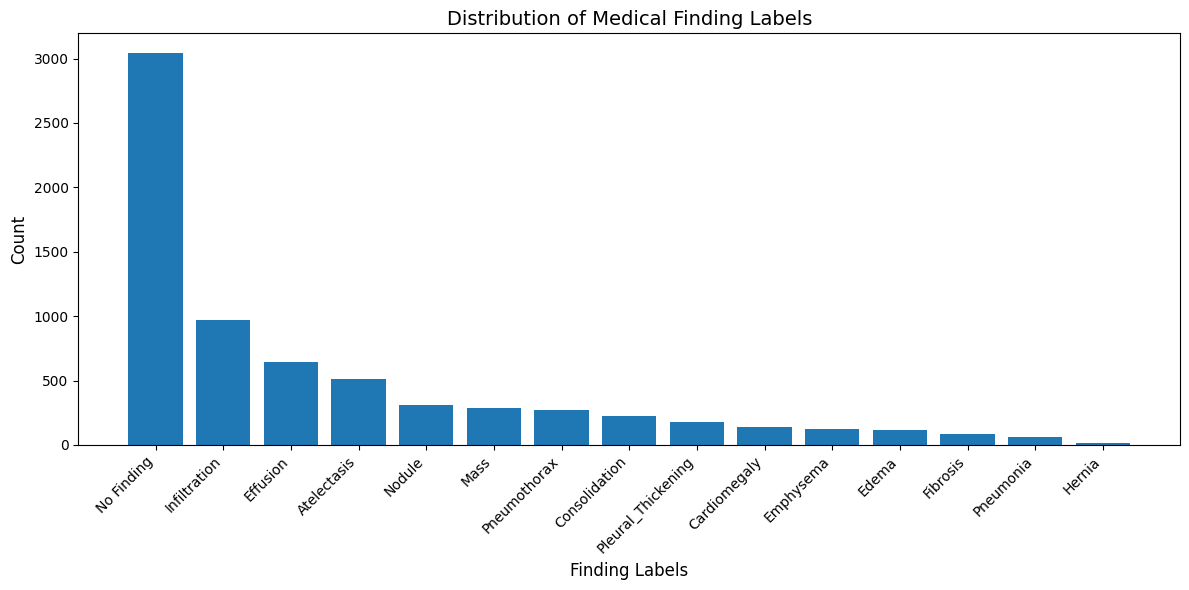

Total unique labels: 15

Label Distribution:
  No Finding: 3044
  Infiltration: 967
  Effusion: 644
  Atelectasis: 508
  Nodule: 313
  Mass: 284
  Pneumothorax: 271
  Consolidation: 226
  Pleural_Thickening: 176
  Cardiomegaly: 141
  Emphysema: 127
  Edema: 118
  Fibrosis: 84
  Pneumonia: 62
  Hernia: 13


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each label
label_counts = {}
for row in df['Finding Labels']:
    for label in row.split('|'):
        label = label.strip()
        if label:
            label_counts[label] = label_counts.get(label, 0) + 1

# Sort by count
label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Finding Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Medical Finding Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total unique labels: {len(label_counts)}")
print(f"\nLabel Distribution:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")

In [6]:

# Filtered out labels with low occurrences
min_occurrences = 500
filtered_labels = {label: count for label, count in label_counts.items() if count >= min_occurrences}
print(f"\nLabels with at least {min_occurrences} occurrences:")
for label, count in filtered_labels.items():
    print(f"  {label}: {count}")


Labels with at least 500 occurrences:
  No Finding: 3044
  Infiltration: 967
  Effusion: 644
  Atelectasis: 508


In [47]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np

class MedicalImageData(torch.utils.data.Dataset):
    def __init__(self, image_path: str, annot_paths: str, transform=None, ids=None):
        self.img_labels = pd.read_csv(annot_paths)
        self.image_path = image_path
        self.transform = transform

        # One-hot encode the multi-labels
        labels_list = []
        for row in self.img_labels['Finding Labels']:
            labels = [label.strip() for label in row.split('|') if label.strip()]
            labels_list.append(labels)
        mlb = MultiLabelBinarizer()
        one_hot_encoded = mlb.fit_transform(labels_list)
        self.label_mapping = mlb.classes_
        self.labels_encoded = np.asarray(one_hot_encoded)
        self.patient_ids = self.img_labels['Patient ID'].nunique()

        # Only keep data for specified ids if provided
        if ids is not None:
            mask = self.img_labels['Patient ID'].isin(ids)
            self.img_labels = self.img_labels[mask].reset_index(drop=True)
            self.labels_encoded = self.labels_encoded[mask.values]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Load the image
        image_name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.image_path, str(image_name))
        image = read_image(img_path)
        
        # Convert to RGB if necessary (handle grayscale or RGBA)
        if image.ndim == 2:  # Grayscale 2D image
            image = image.unsqueeze(0)  # Add channel dimension
        
        if image.shape[0] == 1:  # Grayscale (1 channel)
            image = image.repeat(3, 1, 1)
        elif image.shape[0] == 4:  # RGBA (4 channels)
            image = image[:3]
        elif image.shape[0] > 3:  # More than 3 channels
            image = image[:3]
        
        if self.transform:
            image = self.transform(image)
        # Get the multi-labels
        labels = self.labels_encoded[idx]
        labels = torch.tensor(labels, dtype=torch.float32)
        return image, labels

In [48]:
# Transformations
transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True), # Converts [0-255] to [0.0-1.0],
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

patient_ids = df['Patient ID'].unique()
# Split
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_set = MedicalImageData(
    image_path='dataset/sample/images/',
    annot_paths='dataset/sample/sample_labels.csv',
    transform=transform,
    ids=train_ids
)
test_set = MedicalImageData(
    image_path='dataset/sample/images/',
    annot_paths='dataset/sample/sample_labels.csv',
    transform=transform,
    ids=test_ids
)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

images, labels = next(iter(train_loader))

# Get the loss function
criterion = nn.BCEWithLogitsLoss()

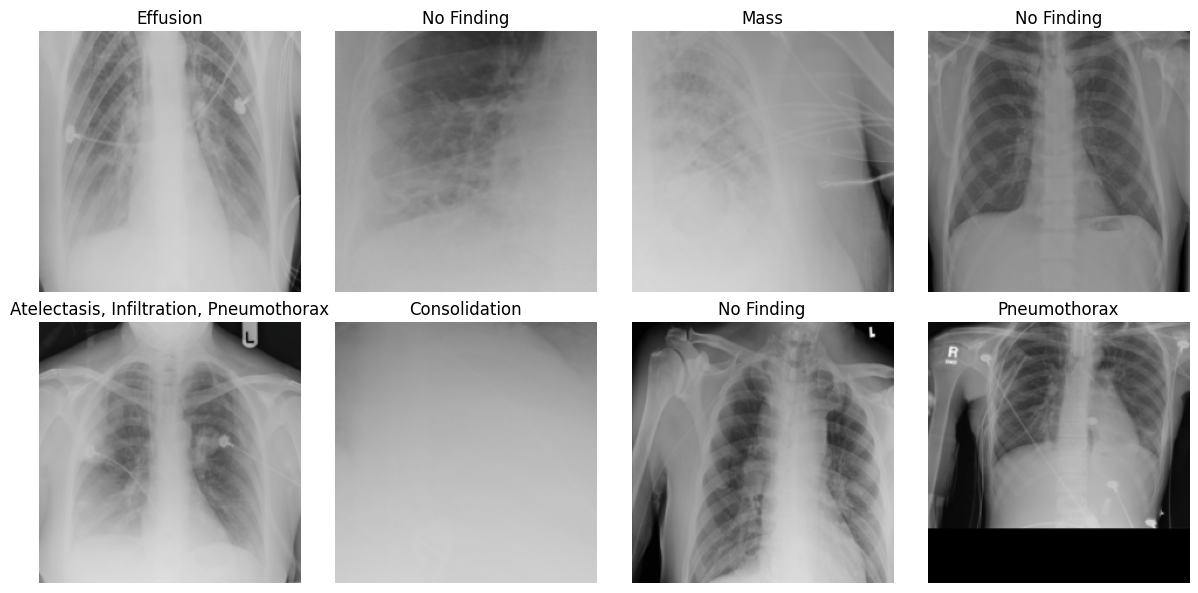

In [49]:
# Plot the first batch of images and their labels
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i // 4, i % 4]
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    label_indices = (labels[i] == 1).nonzero(as_tuple=True)[0].tolist()
    label_names = [train_set.label_mapping[idx] for idx in label_indices]
    ax.set_title(', '.join(label_names) if label_names else 'No Finding')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [53]:
# Create a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = SimpleCNN(num_classes=len(train_set.label_mapping))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

EPOCH = 10
model.train()
for epoch in range(EPOCH):
    running_loss = 0.0
    avg_accuracy = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        predictions = torch.sigmoid(outputs)
        # Threshold at 0.5 to get binary predictions
        predictions = (predictions > 0.5).float()
        accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        avg_accuracy += accuracy
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    avg_accuracy /= len(train_loader)
    print(f'Epoch [{epoch+1}/{EPOCH}], Loss: {epoch_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

Epoch [1/10], Loss: 0.2307
Epoch [2/10], Loss: 0.2201
Epoch [2/10], Loss: 0.2201
Epoch [3/10], Loss: 0.2191
Epoch [3/10], Loss: 0.2191
Epoch [4/10], Loss: 0.2193
Epoch [4/10], Loss: 0.2193
Epoch [5/10], Loss: 0.2184
Epoch [5/10], Loss: 0.2184
Epoch [6/10], Loss: 0.2177
Epoch [6/10], Loss: 0.2177
Epoch [7/10], Loss: 0.2170
Epoch [7/10], Loss: 0.2170
Epoch [8/10], Loss: 0.2179
Epoch [8/10], Loss: 0.2179
Epoch [9/10], Loss: 0.2168
Epoch [9/10], Loss: 0.2168
Epoch [10/10], Loss: 0.2172
Epoch [10/10], Loss: 0.2172


In [ ]:
# Test the model on test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # Convert outputs to probabilities using sigmoid
        predictions = torch.sigmoid(outputs)
        # Threshold at 0.5 to get binary predictions
        predictions = (predictions > 0.5).float()
        
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all predictions and labels
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
h_loss = hamming_loss(all_labels, all_predictions)

print(f'Test Results:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted): {recall:.4f}')
print(f'F1-Score (weighted): {f1:.4f}')
print(f'Hamming Loss: {h_loss:.4f}')


Test Results:
Accuracy: 0.5367
Precision (weighted): 0.2339
Recall (weighted): 0.4358
F1-Score (weighted): 0.3044
Hamming Loss: 0.0772

Per-label Performance:
Atelectasis: Acc=0.9257, Prec=0.0000, Rec=0.0000, F1=0.0000
Cardiomegaly: Acc=0.9694, Prec=0.0000, Rec=0.0000, F1=0.0000
Consolidation: Acc=0.9589, Prec=0.0000, Rec=0.0000, F1=0.0000
Edema: Acc=0.9694, Prec=0.0000, Rec=0.0000, F1=0.0000
Effusion: Acc=0.8872, Prec=0.0000, Rec=0.0000, F1=0.0000
Emphysema: Acc=0.9694, Prec=0.0000, Rec=0.0000, F1=0.0000
Fibrosis: Acc=0.9843, Prec=0.0000, Rec=0.0000, F1=0.0000
Hernia: Acc=0.9983, Prec=0.0000, Rec=0.0000, F1=0.0000
Infiltration: Acc=0.8217, Prec=0.0000, Rec=0.0000, F1=0.0000
Mass: Acc=0.9572, Prec=0.0000, Rec=0.0000, F1=0.0000
No Finding: Acc=0.5367, Prec=0.5367, Rec=1.0000, F1=0.6985
Nodule: Acc=0.9510, Prec=0.0000, Rec=0.0000, F1=0.0000
Pleural_Thickening: Acc=0.9729, Prec=0.0000, Rec=0.0000, F1=0.0000
Pneumonia: Acc=0.9878, Prec=0.0000, Rec=0.0000, F1=0.0000
Pneumothorax: Acc=0.9519